In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 740.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.3 MB/s eta 0:00:00


In [3]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 21.5 MB/s eta 0:00:00


In [5]:
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.4/110.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 844.5/844.5 kB 59.1 MB/s eta 0:00:00


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob as glob
import albumentations as A
import requests
import zipfile

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import PyDataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, Activation, Input,
                                     MaxPool2D, Conv2DTranspose)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

block_plot = False
plt.rcParams['image.cmap'] = 'gray'

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [2]:
def system_config(SEED_VALUE):

    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)

    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)

        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config(7)

[]
Using CPU


In [3]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 2
    IMG_WIDTH:   int = 224
    IMG_HEIGHT:  int = 224
    DATA_TRAIN_IMAGES: str = 'dataset_kitti_road_segmentation/train/images/*.png'
    DATA_TRAIN_LABELS: str = 'dataset_kitti_road_segmentation/train/masks/*.png'
    DATA_VALID_IMAGES: str = 'dataset_kitti_road_segmentation/valid/images/*.png'
    DATA_VALID_LABELS: str = 'dataset_kitti_road_segmentation/valid/masks/*.png'

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 8
    EPOCHS:          int = 51
    LEARNING_RATE: float = 0.0001
    CHECKPOINT_DIR:  str = 'model_checkpoint/FCN_Road'

@dataclass(frozen=True)
class InferenceConfig:
    NUM_BATCHES:     int = 3

In [4]:
# Fully Convolutional Layer (FCN)
def fcn32s_vgg16(num_classes, shape):

    model_input = Input(shape=shape)

    # Conv block 1.
    x = Conv2D(64, (3, 3), padding='same')(model_input)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # Conv block 2.
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # Conv block 3.
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # Conv block 4.
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # Conv block 5.
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D((2, 2), strides=(2, 2))(x)

    # 1x1 convolution to limit the depth of the feature maps to the number of classes.
    x = Conv2D(num_classes, (1, 1), padding='same')(x)

    # Upsampling using Transposed Convolution.
    outputs = Conv2DTranspose(num_classes, kernel_size=(64, 64), strides=(32, 32),  padding='same')(x)

    model_output = Activation('softmax')(outputs)

    model = Model(inputs=model_input, outputs=model_output)

    return model

In [5]:
model = fcn32s_vgg16(num_classes=DatasetConfig.NUM_CLASSES,
                     shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, 3))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             

 Total params: 14,732,100 (56.20 MB)

 Trainable params: 14,732,100 (56.20 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# To Download processed dataset.
def download_file(url, save_name):
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)

In [7]:
# To Unzip the dataset file.
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [8]:
save_name = "dataset_kitti_road_segmentation.zip"

if not os.path.exists(save_name):
    download_file(
        "https://www.dropbox.com/s/6vpsgn4gqtdiu01/dataset_kitti_road_segmentation.zip?dl=1",
        save_name
    )

    unzip(zip_file=save_name)

Extracted all


In [9]:
# Custom Class for creating training and validation (segmentation) dataset objects.
class CustomSegDataLoader(PyDataset):

    def __init__(self, batch_size, image_size, image_paths, mask_paths, num_classes, aug, **kwargs):
        super().__init__(**kwargs)

        self.batch_size  = batch_size
        self.image_size  = image_size
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.num_classes = num_classes
        self.aug = aug

        self.x = np.empty((self.batch_size,) + self.image_size + (3,), dtype="float32")
        self.y = np.empty((self.batch_size,) + self.image_size, dtype="float32")

        if self.aug:
            self.train_transforms = self.transforms()

        self.resize_transforms = self.resize()

    def __len__(self):

        return len(self.mask_paths) // self.batch_size

    def transforms(self):

        # Data augmentation.
        train_transforms = A.Compose([A.HorizontalFlip(p=0.33),])
        return train_transforms

    def resize(self):

        resize_transforms = A.Resize(
            height=self.image_size[0], width=self.image_size[1],
            interpolation=cv2.INTER_NEAREST,
            always_apply=True, p=1
        )
        return resize_transforms

    def reset_array(self):
        self.x.fill(0.)
        self.y.fill(0.)

    def __getitem__(self, idx):
        self.reset_array()
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i : i + self.batch_size]
        batch_mask_paths = self.mask_paths[i : i + self.batch_size]

        for j, (input_image, input_mask) in enumerate(zip(batch_image_paths, batch_mask_paths)):

            # Read the image and convert to RGB.
            img = cv2.imread(input_image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Read the mask and convert to RGB.
            msk = cv2.imread(input_mask)
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)

            # Resize the image and mask.
            resized  = self.resize_transforms(image=img, mask=msk)
            img, msk = resized['image'], resized['mask']

            if self.aug:
                # Apply augmentations.
                train_augment = self.train_transforms(image=img, mask=msk)
                img, msk = train_augment['image'], train_augment['mask']

            # Store image in x.
            self.x[j] = img / 255. # Normalizing image to be in range [0.0, 1.0]

            # Convert RGB segmentation mask to multi-channel (one-hot) encoded arrays where
            # each channel represents a single class whose pixel values are either 0 or 1,
            # where a 1 represents a pixel location associated with the class that corresponds
            # to the channel.
            msk = rgb_to_onehot(msk)

            # Convert the multi-channel (one-hot encoded) mask to a single channel (grayscale)
            # representation whose values contain the class IDs for each class (essentially
            # collapsing the one-hot encoded arrays into a single channel).
            self.y[j] = msk.argmax(-1)

        return self.x, self.y

In [10]:
id2color = {
    0: (255, 0, 0),   # Background: red
    1: (255, 0, 255), # Road: pink
}

id2color_display = {
    0: (0, 0, 0),     # Background: black
    1: (0, 255, 0),   # Road: green
}

In [11]:
# Function to one-hot encode RGB mask labels.
def rgb_to_onehot(rgb_arr, color_map=id2color, num_classes=DatasetConfig.NUM_CLASSES):

    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros( shape, dtype=np.float32 )

    for i, classes in enumerate(color_map):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_map[i], axis=1).reshape(shape[:2])

    return arr

In [12]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=id2color):

    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))

    for k in color_map.keys():
        output[single_layer==k] = color_map[k]

    return np.float32(output) / 255. # return a floating point array in range [0.0, 1.0]

In [13]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

In [14]:
def display_image_and_mask(data_list, color_mask=False, color_map=id2color):

    plt.figure(figsize=(16, 6))
    title = ['GT Image', 'GT Mask', 'Overlayed Mask']

    grayscale_gt_mask = data_list[1]

    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)

    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], rgb_gt_mask)

    data_list.append(overlayed_image.clip(0.0, 1.0))

    for i in range(len(data_list)):
        plt.subplot(1, len(data_list), i+1)
        plt.title(title[i])
        if title[i] == 'GT Mask':
            if color_mask:
                plt.imshow(np.array(rgb_gt_mask))
            else:
                plt.imshow(np.array(grayscale_gt_mask))
        else:
            plt.imshow(np.array(data_list[i]))
        plt.axis('off')

    plt.show()

In [15]:
def create_datasets(aug=False):

    # Training image and mask paths.
    train_images = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_IMAGES}"))
    train_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_LABELS}"))

    # Validation image and mask paths.
    valid_images = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_IMAGES}"))
    valid_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_LABELS}"))

    # Train data loader.
    train_ds = CustomSegDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=train_images,
                                   mask_paths=train_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=aug,
                                   workers = 4,
                                   use_multiprocessing = True
                                  )
    # Validation data loader.
    valid_ds = CustomSegDataLoader(batch_size=TrainingConfig.BATCH_SIZE,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=valid_images,
                                   mask_paths=valid_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=False,
                                   workers = 4,
                                   use_multiprocessing = True
                                  )

    return train_ds, valid_ds

In [16]:
train_ds, valid_ds = create_datasets(aug=True)

/tmp/ipython-input-3174916091.py:34: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  resize_transforms = A.Resize(


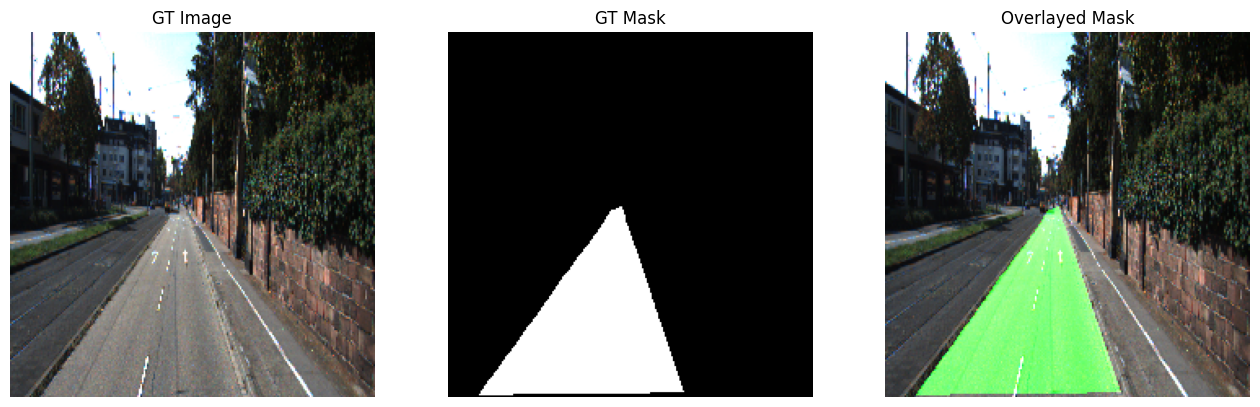

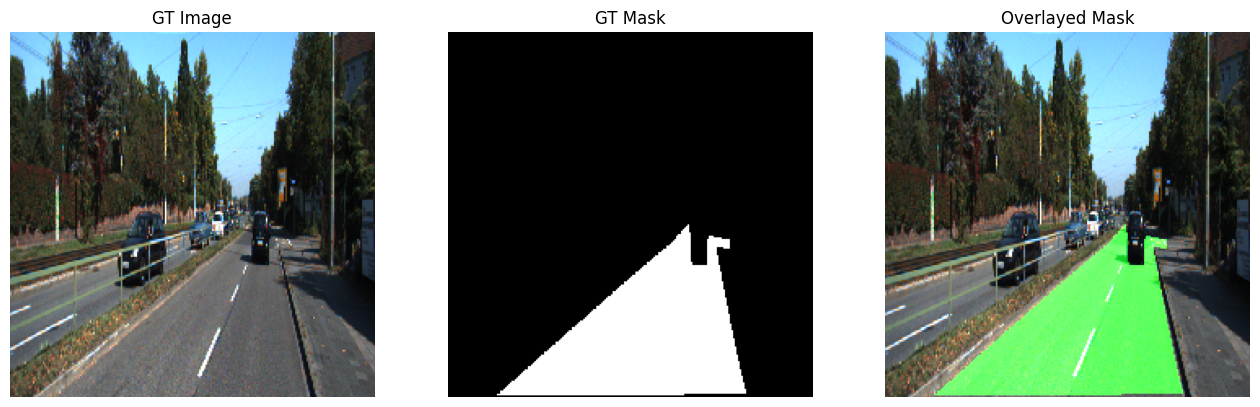

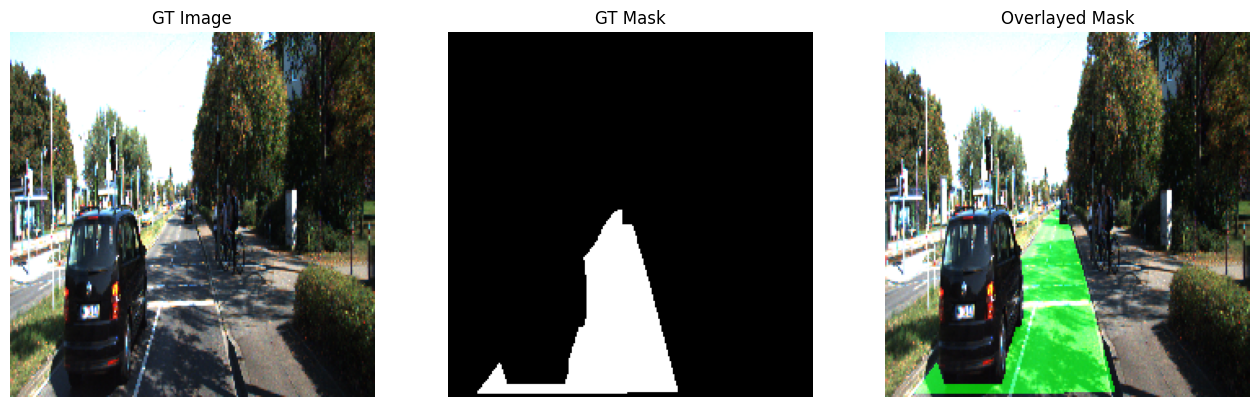

In [17]:
for i, (images, masks) in enumerate(train_ds):
    if i == 3:
        break
    image, mask = images[0], masks[0]
    display_image_and_mask([image, mask], color_mask=False, color_map=id2color_display)

In [18]:
model.compile(optimizer=Adam(learning_rate=TrainingConfig.LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
             )

In [19]:
# Create a new checkpoint directory every time.
if not os.path.exists(TrainingConfig.CHECKPOINT_DIR):
    os.makedirs(TrainingConfig.CHECKPOINT_DIR)

num_versions = len(os.listdir(TrainingConfig.CHECKPOINT_DIR)) + 1
version_dir = TrainingConfig.CHECKPOINT_DIR +'/version_roadseg_' + str(num_versions)
os.makedirs(version_dir)

# Callback to save the best model based on validation loss.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{version_dir}.keras",
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='auto',
                                                               save_best_only=True,
                                                              )

In [ ]:
history = model.fit(train_ds,
                    epochs=TrainingConfig.EPOCHS,
                    verbose=1,
                    validation_data=valid_ds,
                    callbacks=[model_checkpoint_callback],
                   )

Epoch 1/51
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7354 - loss: 0.6895 - val_accuracy: 0.6729 - val_loss: 0.6182
Epoch 2/51
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7185 - loss: 0.5561 - val_accuracy: 0.8473 - val_loss: 0.3120
Epoch 3/51
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8643 - loss: 0.2973 - val_accuracy: 0.9004 - val_loss: 0.2287
Epoch 4/51
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8967 - loss: 0.2485 - val_accuracy: 0.9228 - val_loss: 0.1771
Epoch 5/51
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9241 - loss: 0.1803 - val_accuracy: 0.9304 - val_loss: 0.1662
Epoch 6/51
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9292 - loss: 0.1667 - val_accuracy: 0.9327 - val_loss: 0.1538
Epoch 7/51
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9279 - loss: 0.1609 - val_accuracy: 0.9320 - val_loss: 0.1513
Epoch 8/51
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9262 - loss: 0.1707 - val_accuracy: 0.9379 - val_loss:

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

In [ ]:
# Retrieve the training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

plot_results([ train_acc, valid_acc ],
            ylabel="Pixel Accuracy",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

max_loss = max(max(train_loss), max(valid_loss))

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

In [ ]:
# Performance Inference
trained_model = tf.keras.models.load_model(f"{version_dir}.keras")

In [ ]:
evaluate = trained_model.evaluate(valid_ds)

print(f"Model evaluation accuracy: {evaluate[1]*100.:.3f}")

In [ ]:
def inference(model, dataset):

    num_batches_to_process = InferenceConfig.NUM_BATCHES

    for idx, data in enumerate(dataset):

        batch_img, batch_mask = data[0], data[1]
        pred_all = (model.predict(batch_img)).astype('float32')
        pred_all = pred_all.argmax(-1)
        batch_img = (batch_img * 255).astype('uint8')
        if idx == num_batches_to_process:
            break

        for i in range(0, len(batch_img)):

            fig = plt.figure(figsize=(20,8))

            # Display the original image.
            ax1 = fig.add_subplot(1,4,1)
            ax1.imshow(batch_img[i])
            ax1.title.set_text('Actual frame')
            plt.axis('off')

            # Display the ground truth mask.
            true_mask = batch_mask[i]
            ax2 = fig.add_subplot(1,4,2)
            ax2.set_title('Ground truth labels')
            ax2.imshow(true_mask)
            plt.axis('off')

            # Display the predicted segmentation mask.
            pred_mask = pred_all[i]
            ax3 = fig.add_subplot(1,4,3)
            ax3.set_title('Predicted labels')
            ax3.imshow(pred_mask)
            plt.axis('off')

            # Display the predicted segmentation mask overlayed on the original image.
            pred_mask_rgb = num_to_rgb(pred_all[i], color_map=id2color_display)
            overlayed_image = image_overlay((batch_img[i]), np.array((pred_mask_rgb*255).astype('uint8')))
            ax4 = fig.add_subplot(1,4,4)
            ax4.set_title('Overlayed image')
            ax4.imshow(overlayed_image)
            plt.axis('off')

            plt.show()

In [ ]:
inference(trained_model, valid_ds)